# 0.0. IMPORTS

In [1]:
import pickle
import warnings

import scipy.stats       as ss
import numpy             as np
import pandas            as pd
import seaborn           as sns
import scipy.stats       as ss
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit
from IPython.display         import Image


%matplotlib inline
warnings.filterwarnings( 'ignore' )

## 0.1. Helper Functions

In [6]:
def num_descriptive(num_attributes):
    # Central Tendendy: mean, median
    ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
    ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

    # Dispersion: std, min, max, range, skewness, kurtosis
    d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
    d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
    d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
    d4 = pd.DataFrame(num_attributes.quantile( .25 )).T
    d5 = pd.DataFrame(num_attributes.quantile( .75 )).T
    d6 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
    d7 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
    d8 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

    # concatenating them and printing
    m = pd.concat( [d2, d3, d6, d4,  ct2, d5, ct1, d1, d7, d8] ).T.reset_index()
    m.columns = ['attributes', 'min', 'max', 'range', '25%','median','75%', 'mean', 'std', 'skewness', 'kurtosis'] # renaming columns
    return m

def cramer_v(x, y):
    '''This functions calculates the Cramér V, a measure of association between two nominal variables'''
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k - 1) * (r - 1) / (n - 1))
    
    kcorr = k - (k - 1) ** 2 / (n - 1)
    rcorr = r - (r - 1) ** 2 / (n - 1)
    
    return np.sqrt((chi2corr / n) / min(kcorr - 1, rcorr - 1))

    cm = pd.crosstab(x, y).matrix()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k - 1) * (r - 1) / (n - 1))
    
    kcorr = k - (k - 1) ** 2 / (n - 1)
    rcorr = r - (r - 1) ** 2 / (n - 1)
    
    return np.sqrt((chi2corr / n) / (min(kcorr - 1, rcorr - 1)))

def iqr(data):
    '''Calculate the lower and the upper fences of a variable's boxplot'''
    # IQR weight
    Q1 = np.quantile(data, .25)
    Q3 = np.quantile(data, .75)
    interquartile = Q3 - Q1

    # calculate lower fence and using its value to eliminate outliers
    upper_fence = Q3 + (1.5 * interquartile)
    lower_fence = Q1 - (1.5 * interquartile)
        
    return print('For {}, the lower fence is {} and the upper is {}.'.format(data.name, lower_fence, upper_fence))

## 0.2. Data Collection

In [8]:
df_raw = pd.read_csv('data/cardio_train.csv', sep = ';')

In [16]:
# splitting dataset into train and test
splitting = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=42)
for train_index, test_index in splitting.split(df_raw, df_raw['cardio']):
    train_dataset = df_raw.loc[train_index].reset_index(drop=True)
    test_dataset = df_raw.loc[test_index].reset_index(drop=True)

pickle.dump( train_dataset, open( 'data/train_dataset.pkl', 'wb') )
pickle.dump( test_dataset, open( 'data/test_dataset.pkl', 'wb') )

In [16]:
# loading the train dataset
df_raw = pickle.load(open('../data/train_dataset.pkl', 'rb'))

# 1.0. STEP 01: DATA DESCRIPTION

In [17]:
df1 = df_raw.copy()

## 1.1. Data Dimensions

In [20]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 59500
Number of Columns: 13


## 1.2. Data Types

In [21]:
df1.dtypes

id               int64
age              int64
gender           int64
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol      int64
gluc             int64
smoke            int64
alco             int64
active           int64
cardio           int64
dtype: object

##  1.3. Checking for Missing Values

In [22]:
df1.isna().sum()

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

## 1.4. Changing Data Types

In [81]:
# optimize memory
df1['age'] = df1['age'].astype(np.int16)
df1['height'] = df1['height'].astype(np.int16)
df1['ap_hi'] = df1['ap_hi'].astype(np.int16)
df1['ap_lo'] = df1['ap_lo'].astype(np.int16)
df1['cholesterol'] = df1['cholesterol'].astype(np.int8)
df1['gluc'] = df1['gluc'].astype(np.int8)
df1['smoke'] = df1['smoke'].astype(np.int8)
df1['alco'] = df1['alco'].astype(np.int8)
df1['active'] = df1['active'].astype(np.int8)
df1['cardio'] = df1['cardio'].astype(np.int8)

## 1.5. Checking the Target Balance

In [23]:
df1['cardio'].value_counts(normalize=True)

0    0.500303
1    0.499697
Name: cardio, dtype: float64

##  1.6. Descriptive Statistics

In [25]:
num_attributes = df1[['age', 'height', 'weight', 'ap_hi', 'ap_lo']]
cat_attributes = df1.drop(['id','age', 'height', 'weight', 'ap_hi', 'ap_lo'], axis = 1)

### 1.6.1. Numerical Variables

In [28]:
num_descriptive(num_attributes) # fucntion defined in section 0.1: Helper Functions

,attributes,min,max,range,25%,median,75%,mean,std,skewness,kurtosis
0,age,10859.0,23713.0,12854.0,17666.0,19701.0,21323.0,19467.818723,2464.461515,-0.306813,-0.821627
1,height,57.0,250.0,193.0,159.0,165.0,170.0,164.356134,8.219900,-0.699524,8.419455
2,weight,10.0,200.0,190.0,65.0,72.0,82.0,74.236224,14.405220,1.014289,2.604470
3,ap_hi,-150.0,16020.0,16170.0,120.0,120.0,140.0,129.164336,166.842118,78.923250,6473.852748
4,ap_lo,-70.0,11000.0,11070.0,80.0,80.0,90.0,96.957261,193.625192,31.781300,1374.561201


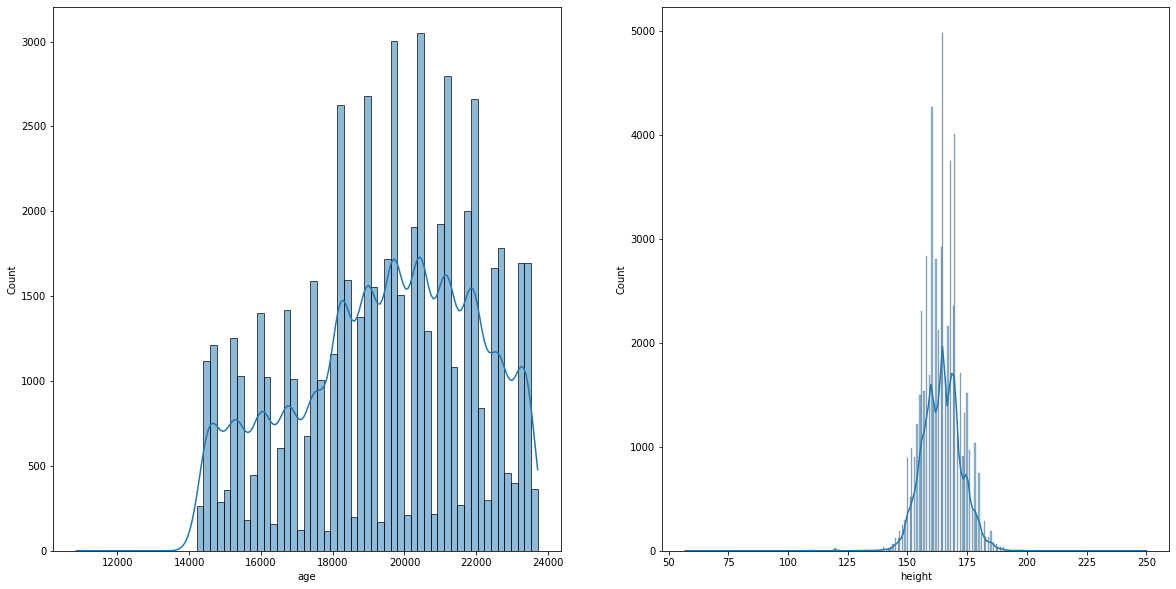

In [79]:
plt.subplots( figsize = ( 20,10 ) )
plt.subplot(1, 2, 1);
sns.histplot(num_attributes['age'], kde=True)

plt.subplot(1, 2, 2);
sns.histplot(num_attributes['height'], kde=True);

### 1.6.2. Categorical Variables

In [37]:
cat_list = cat_attributes.columns.tolist()

corr_dict = {}

for i in range(len(cat_list)):
    corr_list = []
    for j in range(len(cat_list)):
        ref = cat_list[i]
        feat = cat_list[j]
        
        # correlation
        corr = cramer_v(cat_attributes[ref], cat_attributes[feat])
        
        # append
        corr_list.append(corr)
    
    corr_dict[ref] = corr_list

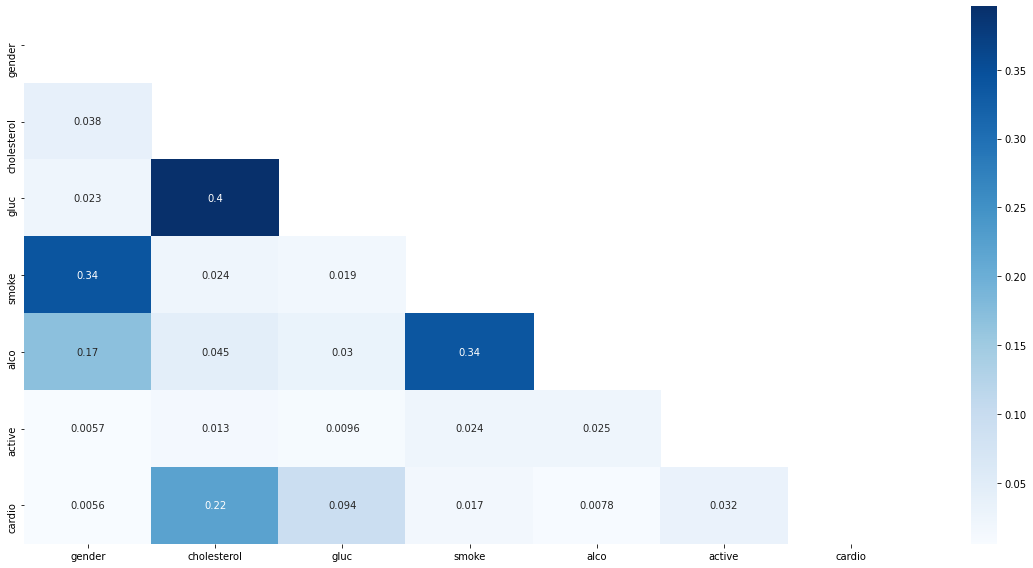

In [42]:
cat_corr = pd.DataFrame(corr_dict)
cat_corr = cat_corr.set_index(cat_corr.columns)
mask = np.zeros_like( cat_corr, dtype=np.bool )
mask[np.triu_indices_from( mask )] = True

plt.subplots( figsize = ( 16,8 ) )
sns.heatmap( cat_corr, cmap='Blues', mask = mask, annot=True)
plt.tight_layout();

# 2.0. STEP 02: FEATURE ENGINEERING

In [155]:
df2 = df1.copy()

## 2.1. Hypothesis Mind Map

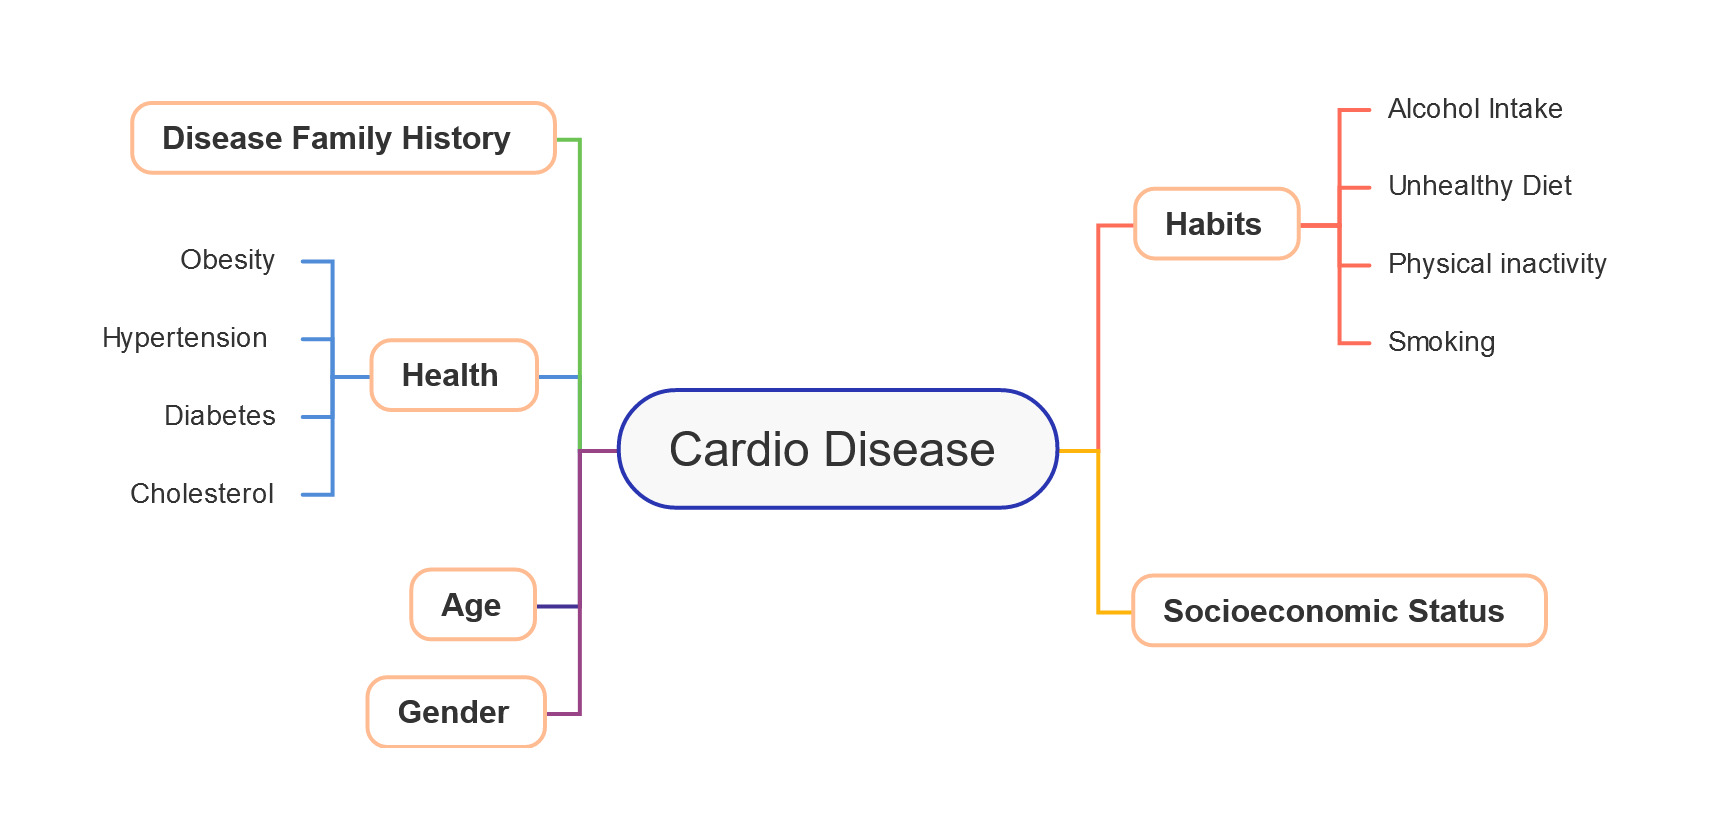

In [48]:
Image( 'imgs/mind_map.jpg' )

##  2.2. Business Hypothesis List

**1.** The proportion of patients with CVD increases after the age of 65.

**2.** Among phisically inactive and obese patients, at least 30% have CVD.

**3.** There are more patients with CVD in early stages among men than among women.

**4.** At least 30% of patients who smoke and are obese have CVD.

**5.** At least 30% of patients with CVD have an unhealthy diet.

**7.** There are at least 20% of patients who drinks alcohol and have a high blood pressure with CVD.

**8.** Among obese patients who have a high blood pressure, at least 30% have CVD.

**9.** Among obese patients who have a cholesterol above normal, at least 30% have CVD.

**10.** Among patients with CVD, the proportion of them who have diabets is at least 10% higher than those who don't have.

**11.** Among patients over the age of 65 who have a high blood pressure, at least 30% have CVD.

##  2.3. Hypothesis Final List: adapted for the availability of data.

**1.** The proportion of patients with CVD is higher among those aged 50 or above.

**2.** The number of patients with CVD surpass the non CVD number at the age of 50.

**3.** The number of patients with CVD surpass the non CVD number at the BMI of 30 (obese).

**4.** The proportion of patients with CVD in early stages is higher among men than among women.

**5.** The proportion of hypertensive patients with CVD is higher among those who smoke.

**6.** Among patients over the age of 60 who have a high blood pressure, more than 50% have CVD.

**7.** The number of patients with CVD is higher among those who have a glucose level above or well above normal.

**8.** The proportion of patients with CVD is at least 20% higher among those who drink alcohol.

**9.**  Among obese patients who have a high blood pressure, at least 50% have CVD.

**10.** Among patients with CVD, the proportion of those with a cholesterol level above/well above normal is higher in obese patients.

## 2.4. Feature Engineering

In [156]:
# height
df2['height'] = df2['height'] / 100

# bmi and bmi levels
df2['bmi'] = round(df2['weight'] / (df2['height'])**2, 3)

df2['bmi_levels'] = df2['bmi'].apply( lambda x: 'underweight' if x < 18.5 
                                     else 'normal' if (x >= 18.5) & (x < 25)
                                     else 'overweight' if (x >= 25) & (x < 30)
                                     else 'obese' if (x >= 30) & (x < 35)
                                     else 'extremely_obese'
                                    )

# blood pressure levels
# # df2['blood_pressure'] = df2.apply( lambda x: 'low_pressure' if (x['ap_hi'] < 90) or (x['ap_lo'] < 60)
#                                      else 'normal' if ((x['ap_hi'] >= 90) and  (x['ap_hi'] <= 120)) & ((x['ap_lo'] >= 60) and  (x['ap_lo'] <= 80))
#                                      else 'elevated' if ((x['ap_hi'] > 120) and  (x['ap_hi'] <= 139)) or ((x['ap_lo'] > 80) and  (x['ap_lo'] <= 89))
#                                      else 'hypertension_1' if ((x['ap_hi'] > 139) and  (x['ap_hi'] <= 159)) or ((x['ap_lo'] > 89) and  (x['ap_lo'] <= 99))
#                                      else 'hypertension_2' if ((x['ap_hi'] > 159) and  (x['ap_hi'] <= 179)) or ((x['ap_lo'] > 99) and  (x['ap_lo'] <= 109))                          
#                                      else 'hypertension_3', axis = 1
#                                     )
df2['blood_pressure'] = df2.apply( lambda x: 'low_pressure' if (x['ap_hi'] < 90) or (x['ap_lo'] < 60)
                                     else 'normal' if ((x['ap_hi'] >= 90) and  (x['ap_hi'] <= 120)) & ((x['ap_lo'] >= 60) and  (x['ap_lo'] <= 80))
                                     else 'elevated' if ((x['ap_hi'] > 120) and  (x['ap_hi'] <= 139)) or ((x['ap_lo'] > 80) and  (x['ap_lo'] <= 89))
                                     else 'hypertension', axis = 1
                                    )
# age
df2['age'] = round(df2['age'] / 365).astype(int)

# 

## 2.5. Dealing With Outliers

First let's take a look at the interquantile ranges for for the numerical variables

In [105]:
iqr(df2['height'])
iqr(df2['weight'])
iqr(df2['ap_hi'])
iqr(df2['ap_lo'])

For height, the lower fence is 1.4250000000000003 and the upper is 1.8649999999999998.
For weight, the lower fence is 39.5 and the upper is 107.5.
For ap_hi, the lower fence is 90.0 and the upper is 170.0.
For ap_lo, the lower fence is 65.0 and the upper is 105.0.


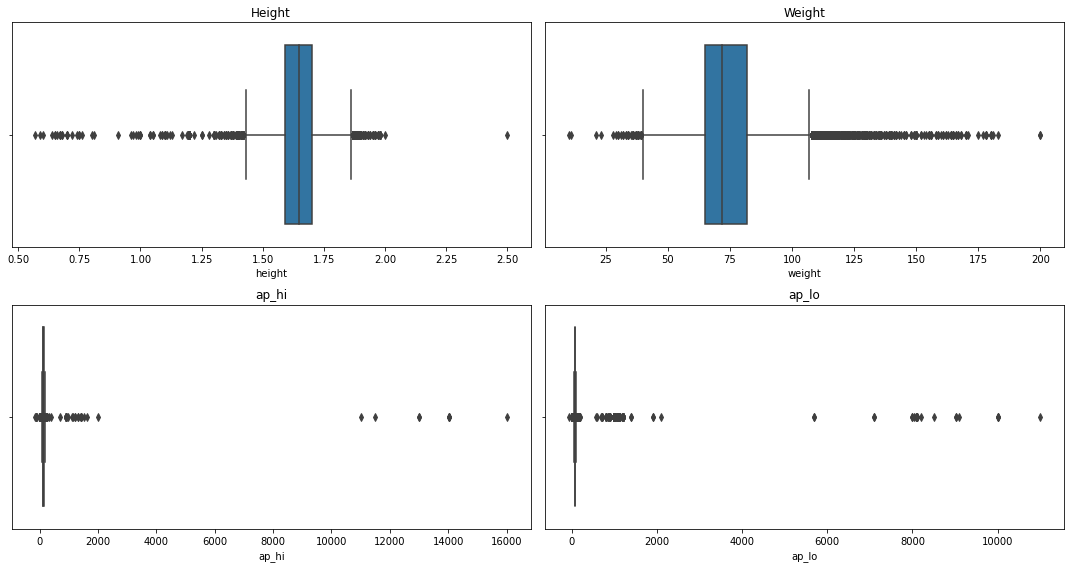

In [165]:
plt.figure(figsize=[15,8])

plt.subplot(2,2,1)
sns.boxplot(x = df2['height'])
plt.title('Height')

plt.subplot(2,2,2)
sns.boxplot(x = df2['weight'])
plt.title('Weight')

plt.subplot(2,2,3)
sns.boxplot(x = df2['ap_hi'])
plt.title('ap_hi')

plt.subplot(2,2,4)
sns.boxplot(x = df2['ap_lo'])
plt.title('ap_lo')
plt.tight_layout();

### 2.5.1 Height

We found that people with dwarfism average height is about 122cm [see here](https://www.mayoclinic.org/diseases-conditions/dwarfism/symptoms-causes/syc-20371969). Besides that, it's not to common poeple tallest than 2.4 meters [see here](https://en.wikipedia.org/wiki/List_of_tallest_people). So, for this project cycle, we'll filter the dataset around those boundaries taking the risk of loosing information or being making mistakes. In the next cycle, those data will be better handled.

In [157]:
df2 = df2[(df2['height'] >= 1.1) & (df2['height'] <= 2.2)]

### 2.5.2. Weight

For this cycle, we'll just remove patient data which the weight is less than a 10 years old boy/girl average weight: 32kg.

In [158]:
df2 = df2[df2['weight'] >= 33]

In [69]:
df2.shape

(59451, 16)

### 2.5.3. ap_hi

There are some extremely large values of systolic in the dataset. We'll consider them as inconsistent data and remove them. We'll limit to 220, which is an acceptable value for a human being.

As shown in the descriptive statistics, there are some negative values. We'll consider only values greater than 85, since a value below 90 indicates that the person needs medical care. Again, this person could be a sick one, but we won't consider this assumption in this cycle.

In [23]:
df2['ap_hi'].sort_values(ascending = False).head()

16681    16020
46746    14020
35652    14020
15117    14020
55743    14020
Name: ap_hi, dtype: int64

In [159]:
df2 = df2[(df2['ap_hi'] >=85) & (df2['ap_hi'] <= 240)]

### 2.5.4. ap_lo

It's almost the same we did with `ap_hi`, but the boundaries are different. Here, we'll consider 150 as the maximum value and 65 as the minimum.

In [169]:
df2['ap_lo'].sort_values(ascending = False).head()

42144    11000
13720    10000
30619    10000
25445    10000
50212     9100
Name: ap_lo, dtype: int16

In [160]:
df2 = df2[(df2['ap_lo'] >=65) & (df2['ap_lo'] <= 150)]

### 2.5.4. Proportion of removed data

In [161]:
# how many outliers were removed from the dataset
print('{:.2f}% of the data were removed.'.format((100 - (df2.shape[0]/59500)*100)))

6.02% of the data were removed.


# 3.0. STEP 03: DATA FILTERING

In [162]:
pickle.dump( df2, open( '../data/df2.pkl', 'wb'))
df3 = pickle.load(open('../data/df2.pkl', 'rb'))

# 4.0. STEP 04: EXPLORATORY DATA ANALYSIS

In [47]:
df4 = pickle.load(open('../data/df2.pkl', 'rb'))

In [50]:
num_attributes = df4[['age', 'height', 'weight', 'ap_hi', 'ap_lo', 'bmi']]
cat_attributes = df4.drop(['id','age', 'height', 'weight', 'ap_hi', 'ap_lo', 'bmi'], axis=1)

## 4.1. Univariate Analysis

### 4.1.1. Response Variable

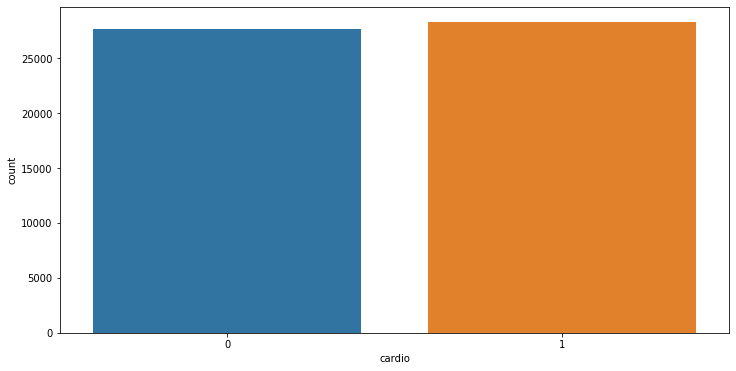

In [14]:
plt.figure(figsize=[12,6])
sns.countplot('cardio', data = df4);

### 4.1.2. Numerical Variables

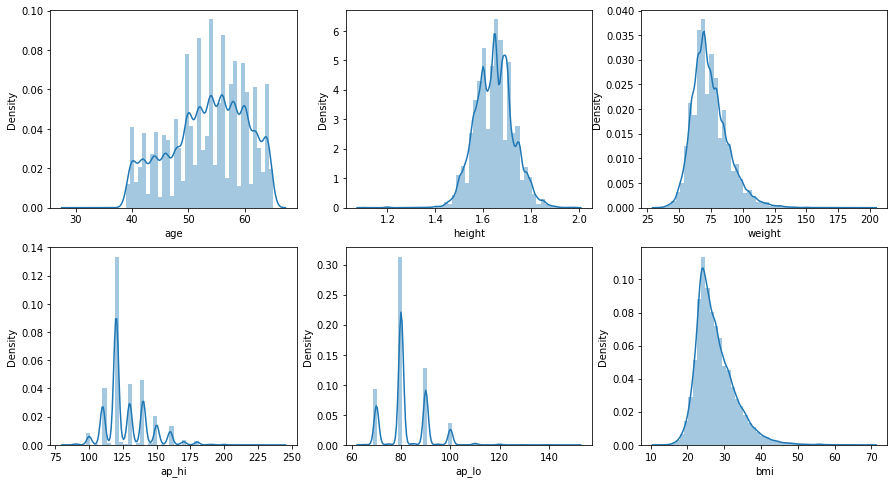

In [27]:
plt.figure(figsize = [15,8])

plt.subplot(2,3,1)
sns.distplot(num_attributes['age'])

plt.subplot(2,3,2)
sns.distplot(num_attributes['height'])

plt.subplot(2,3,3)
sns.distplot(num_attributes['weight'])

plt.subplot(2,3,4)
sns.distplot(num_attributes['ap_hi'])

plt.subplot(2,3,5)
sns.distplot(num_attributes['ap_lo'])

plt.subplot(2,3,6)
sns.distplot(num_attributes[num_attributes['bmi']<= 70]['bmi']);

### 4.1.3.Categorical Variables

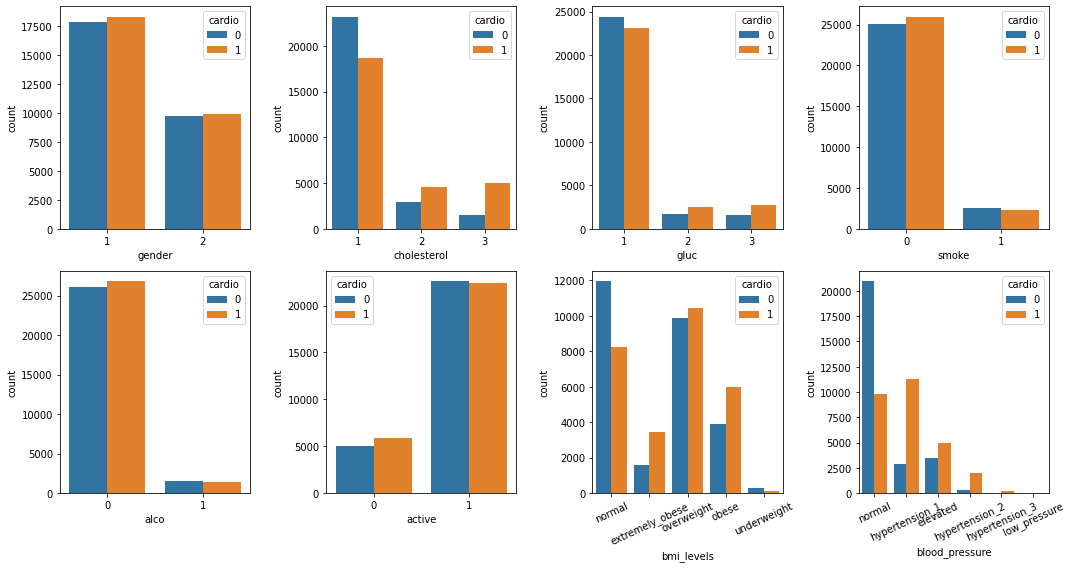

In [36]:
plt.figure(figsize = [15,8])

plt.subplot(2,4,1)
sns.countplot('gender', hue = 'cardio', data = cat_attributes)

plt.subplot(2,4,2)
sns.countplot('cholesterol', hue = 'cardio', data = cat_attributes)

plt.subplot(2,4,3)
sns.countplot('gluc', hue = 'cardio', data = cat_attributes)

plt.subplot(2,4,4)
sns.countplot('smoke', hue = 'cardio', data = cat_attributes)

plt.subplot(2,4,5)
sns.countplot('alco', hue = 'cardio', data = cat_attributes)

plt.subplot(2,4,6)
sns.countplot('active', hue = 'cardio', data = cat_attributes)

plt.subplot(2,4,7)
sns.countplot('bmi_levels', hue = 'cardio', data = cat_attributes)
plt.xticks(rotation = 25)

plt.subplot(2,4,8)
sns.countplot('blood_pressure', hue = 'cardio', data = cat_attributes)
plt.xticks(rotation = 25)

plt.tight_layout();

## 4.2. Bivariate Analysis

### H1: The proportion of patients with CVD is higher among those aged 50 or above.
**<font color='green'>TRUE</font>**: the proportion of patients with CVD is higher among those aged 50 or above.

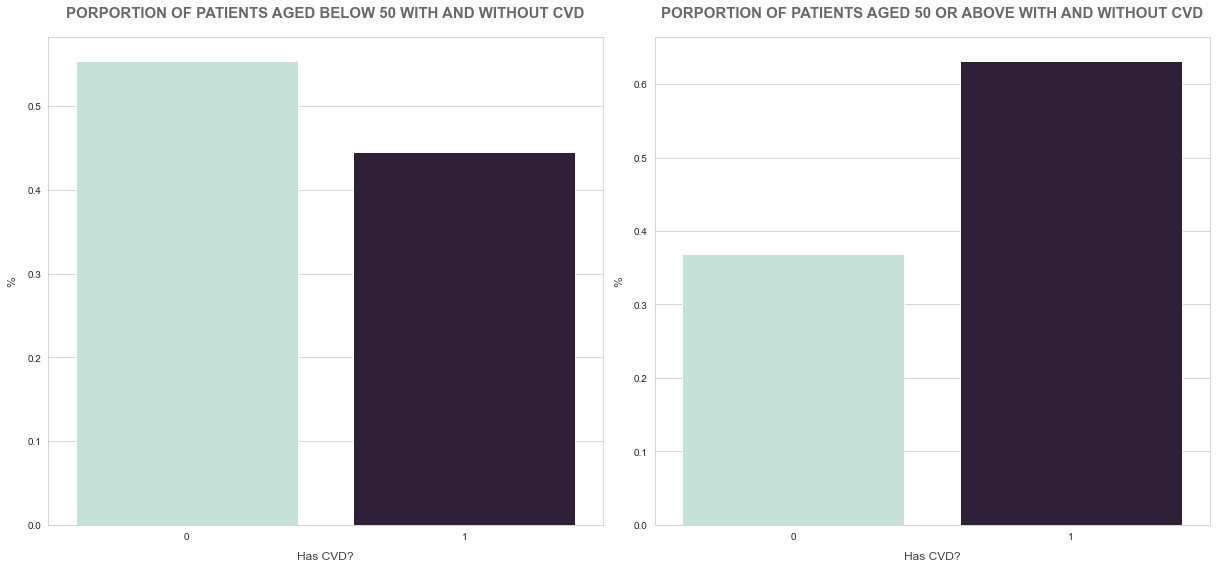

In [22]:
aux1 = df4[df4['age'] < 50]
aux2 = df4[df4['age'] >= 50]

plt.figure(figsize=[17,8])
plt.subplot(1,2,1)
sns.barplot(x=aux1.cardio.value_counts(normalize=True).index, y=aux2.cardio.value_counts(normalize=True), palette='ch:start=.5,rot=-.5')
plt.title('PORPORTION OF PATIENTS AGED BELOW 50 WITH AND WITHOUT CVD', 
          pad = 20,
         fontsize = 15, color ='dimgrey', fontweight = 'bold')
plt.xlabel('Has CVD?', color = '#414141', labelpad = 10, fontsize = 12)
plt.ylabel('%', color = '#414141', labelpad = 10, fontsize = 12)

plt.subplot(1,2,2)
sns.barplot(x=aux2.cardio.value_counts(normalize=True).index, y=aux1.cardio.value_counts(normalize=True), palette='ch:start=.5,rot=-.5')
plt.title('PORPORTION OF PATIENTS AGED 50 OR ABOVE WITH AND WITHOUT CVD', 
          pad = 20,
         fontsize = 15, color ='dimgrey', fontweight = 'bold')
plt.xlabel('Has CVD?', color = '#414141', labelpad = 10, fontsize = 12)
plt.ylabel('%', color = '#414141', labelpad = 10, fontsize = 12)
plt.tight_layout();

### H2: The number of patients with CVD surpass the non CVD number at the age of 50.
**<font color='red'>FALSE</font>**: the number of patients with CVD surpass the non CVD at the age of 56.

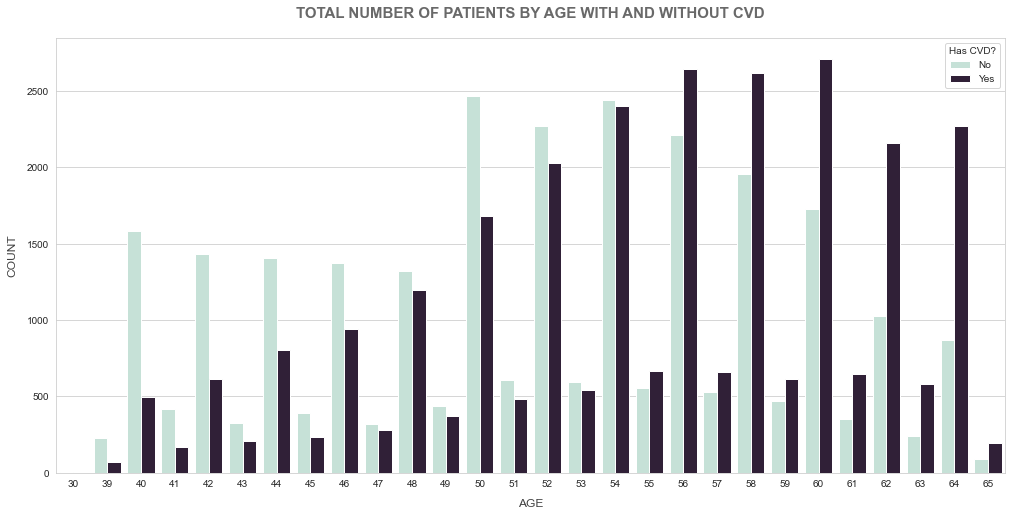

In [29]:
plt.figure(figsize=[17,8])
sns.countplot('age', hue = 'cardio', data = df4 ,palette="ch:start=.5,rot=-.5")
plt.title('TOTAL NUMBER OF PATIENTS BY AGE WITH AND WITHOUT CVD', 
          pad = 20,
         fontsize = 15, color ='dimgrey', fontweight = 'bold')
plt.xlabel('AGE', color = '#414141', labelpad = 10, fontsize = 12)
plt.ylabel('COUNT', color = '#414141', labelpad = 10, fontsize = 12)
plt.legend(title = 'Has CVD?', labels=['No', 'Yes']);

### H3: The number of patients with CVD surpass the non CVD number at the BMI of 30 (obese).
**<font color='red'>FALSE</font>**: the number of patients with CVD surpass the non CVD at the BMI between 27 and 28. Thenceforth, the number of patients with CVD is always higher.

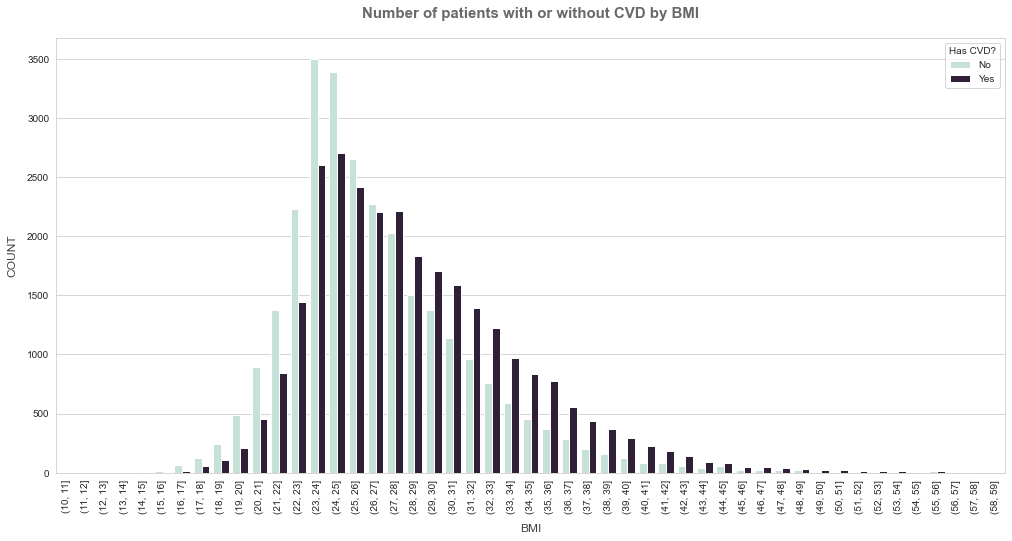

In [30]:
# setting bins
bins = list(np.arange(10,60))
aux = df4[['bmi', 'cardio']]
aux['bmi'] = pd.cut(aux['bmi'], bins = bins)

#plotting
plt.figure(figsize = (17,8))
sns.countplot('bmi', hue = 'cardio', data = aux, palette='ch:start=.5,rot=-.5')
plt.title('Number of patients with or without CVD by BMI', 
          pad = 20,
         fontsize = 15, color ='dimgrey', fontweight = 'bold')
plt.xlabel('BMI', color = '#414141', labelpad = 10, fontsize = 12)
plt.ylabel('COUNT', color = '#414141', labelpad = 10, fontsize = 12)
plt.legend(title = 'Has CVD?', labels=['No', 'Yes']);
plt.xticks(rotation = 90);

### H4: The proportion of patients with CVD in early stages is higher among men than among women.
**<font color='grey'>CAN'T SAY</font>**: the dataset source didn't provide any information about what `gender` value stands for men and for women. We could analyze the data, such as the average weight and height, to deduct it, but for this CRISP-DM cycle we won't deal with this feature.

But we can conclude that there are a little difference between the proportion among the two genders, so we'll need further investigation.

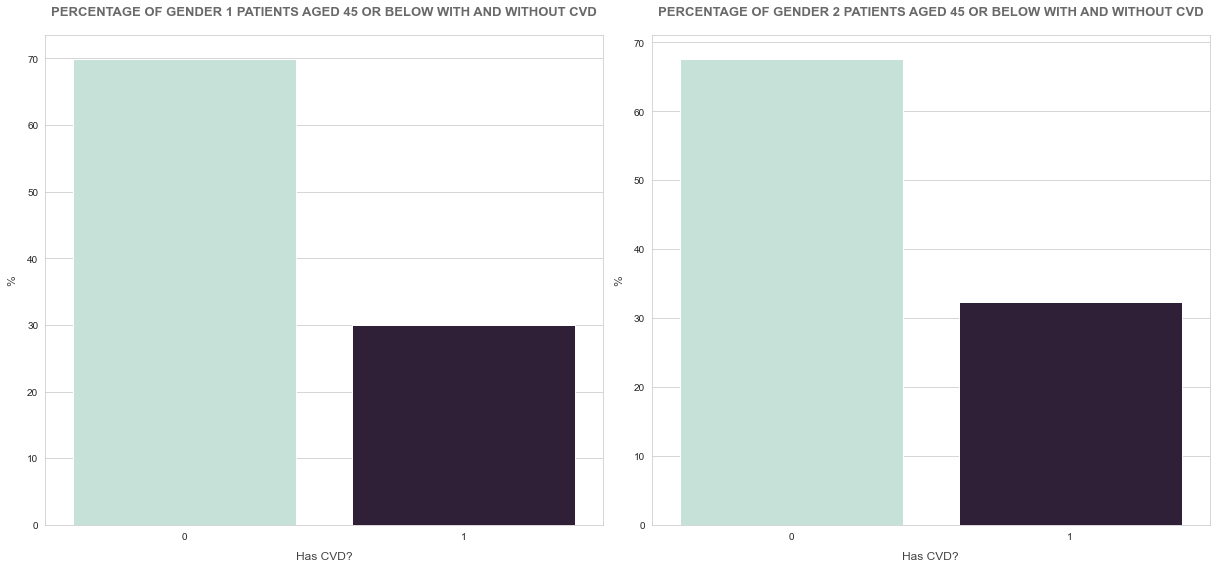

In [38]:
aux1 = df4[(df4['gender'] == 1) & (df4['age'] <= 45)]
aux2 = df4[(df4['gender'] == 2) & (df4['age'] <= 45)]
# aggregate data
# aux1 = (aux1[['gender','cardio']].groupby('cardio').count()/len(aux1)*100).reset_index()
# aux2 = (aux2[['gender','cardio']].groupby('cardio').count()/len(aux2)*100).reset_index()
# set plot

plt.figure(figsize=[17,8])

plt.subplot(1,2,1)
sns.barplot(x = 'cardio', y = 'gender', palette='ch:start=.5,rot=-.5',data = (aux1[['gender','cardio']].groupby('cardio').count()/len(aux1)*100).reset_index())
plt.title('PERCENTAGE OF GENDER 1 PATIENTS AGED 45 OR BELOW WITH AND WITHOUT CVD', 
          pad = 20,
         fontsize = 13, color ='dimgrey', fontweight = 'bold')
plt.xlabel('Has CVD?', color = '#414141', labelpad = 10, fontsize = 12)
plt.ylabel('%', color = '#414141', labelpad = 10, fontsize = 12)
plt.tight_layout()

plt.subplot(1,2,2)
sns.barplot(x = 'cardio', y = 'gender', palette='ch:start=.5,rot=-.5', data = (aux2[['gender','cardio']].groupby('cardio').count()/len(aux2)*100).reset_index());
plt.title('PERCENTAGE OF GENDER 2 PATIENTS AGED 45 OR BELOW WITH AND WITHOUT CVD', 
          pad = 20,
         fontsize = 13, color ='dimgrey', fontweight = 'bold')
plt.xlabel('Has CVD?', color = '#414141', labelpad = 10, fontsize = 12)
plt.ylabel('%', color = '#414141', labelpad = 10, fontsize = 12)
plt.tight_layout();

### H5: The proportion of hypertensive patients with CVD is higher among those who smoke.
**<font color='red'>FALSE</font>**: the proportion of hypertensive patients that have CVD is almost the same between smokers and non-smokers (there are around 20% of patients with CVD)

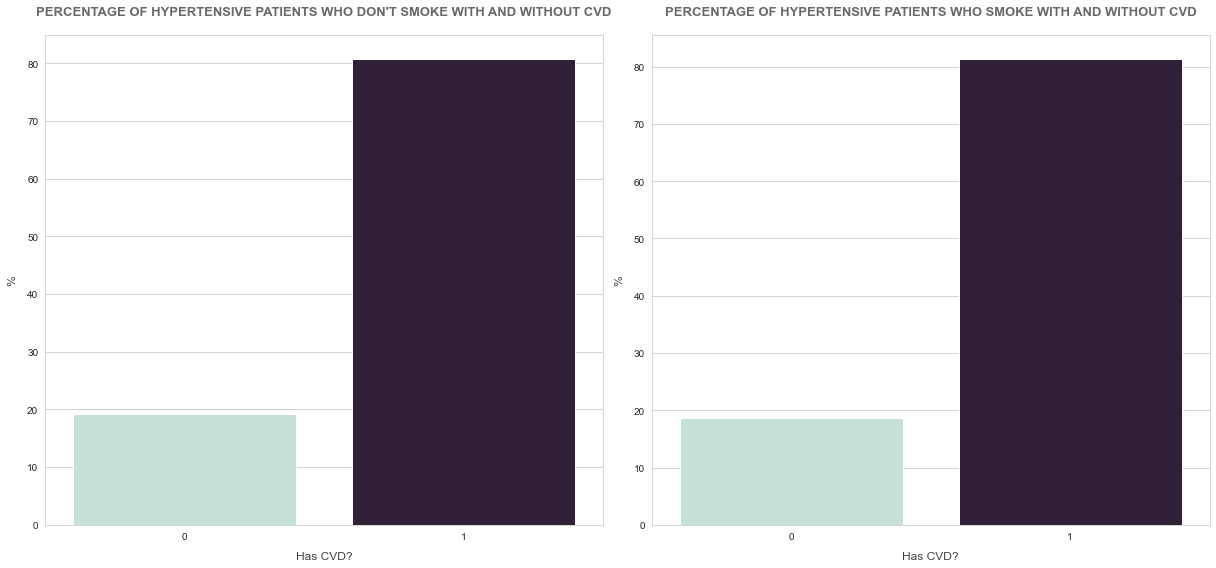

In [49]:
aux1 = df4[(df4['smoke'] == 0) & (df4['blood_pressure'] =='hypertension')]
aux2 = df4[(df4['smoke'] == 1) & (df4['blood_pressure'] =='hypertension')]
# aggregate data
# aux1 = (aux1[['gender','cardio']].groupby('cardio').count()/len(aux1)*100).reset_index()
# aux2 = (aux2[['gender','cardio']].groupby('cardio').count()/len(aux2)*100).reset_index()
# set plot

plt.figure(figsize=[17,8])

plt.subplot(1,2,1)
sns.barplot(x = 'cardio', y = 'smoke', palette='ch:start=.5,rot=-.5',data = (aux1[['smoke','cardio']].groupby('cardio').count()/len(aux1)*100).reset_index())
plt.title('PERCENTAGE OF HYPERTENSIVE PATIENTS WHO DON\'T SMOKE WITH AND WITHOUT CVD', 
          pad = 20,
         fontsize = 13, color ='dimgrey', fontweight = 'bold')
plt.xlabel('Has CVD?', color = '#414141', labelpad = 10, fontsize = 12)
plt.ylabel('%', color = '#414141', labelpad = 10, fontsize = 12)
plt.tight_layout();

plt.subplot(1,2,2)
sns.barplot(x = 'cardio', y = 'smoke', palette='ch:start=.5,rot=-.5', data = (aux2[['smoke','cardio']].groupby('cardio').count()/len(aux2)*100).reset_index());
plt.title('PERCENTAGE OF HYPERTENSIVE PATIENTS WHO SMOKE WITH AND WITHOUT CVD', 
          pad = 20,
         fontsize = 13, color ='dimgrey', fontweight = 'bold')
plt.xlabel('Has CVD?', color = '#414141', labelpad = 10, fontsize = 12)
plt.ylabel('%', color = '#414141', labelpad = 10, fontsize = 12)
plt.tight_layout();

### H6: Among patients over the age of 60 who have a high blood pressure, more than 50% have CVD.
**<font color='green'>TRUE</font>**: more than 80% of the hypertensive patients aged 60 or above have CVD.

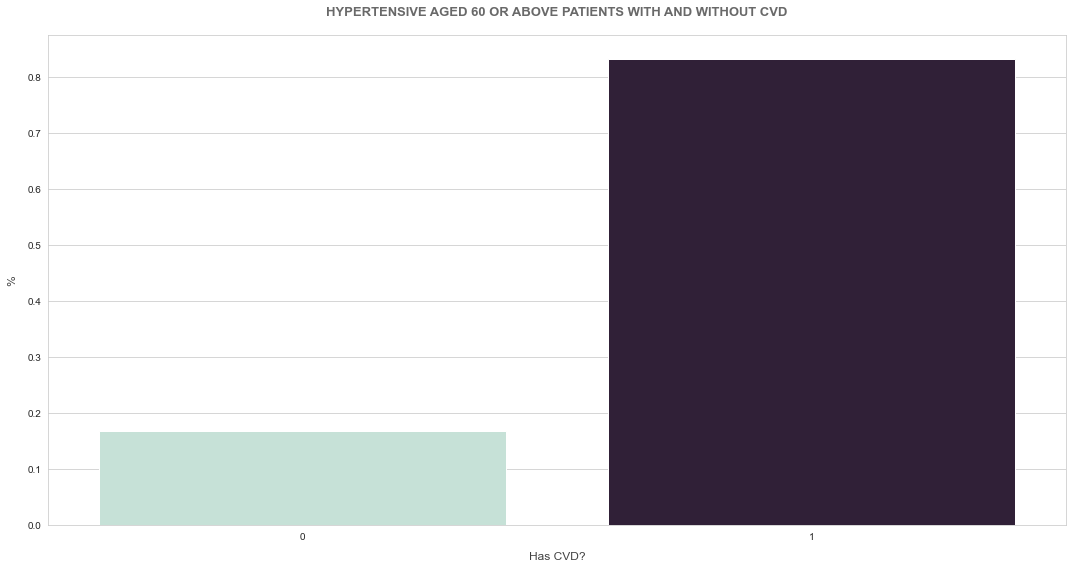

In [50]:
aux1 = df4[(df4['age'] >=60) & (df4['blood_pressure'] =='hypertension')]

plt.figure(figsize=[15,8])
sns.barplot(x=aux1.cardio.value_counts(normalize=True).index, y=aux1.cardio.value_counts(normalize=True), palette='ch:start=.5,rot=-.5')
plt.title('HYPERTENSIVE AGED 60 OR ABOVE PATIENTS WITH AND WITHOUT CVD', 
          pad = 20,
         fontsize = 13, color ='dimgrey', fontweight = 'bold')
plt.xlabel('Has CVD?', color = '#414141', labelpad = 10, fontsize = 12)
plt.ylabel('%', color = '#414141', labelpad = 10, fontsize = 12)
plt.tight_layout();

### H7: The number of patients with CVD is higher among those who have a glucose level above or well above normal.
**<font color='green'>TRUE</font>**: the number of patients with CVD is higher among those who have a glucose level above or well above normal.

As we can see in section 4.1.3, the variable `gluc` is very imbalanced. So, we'll take each `gluc` class and look at the proportion of patients with and without CVD among them.

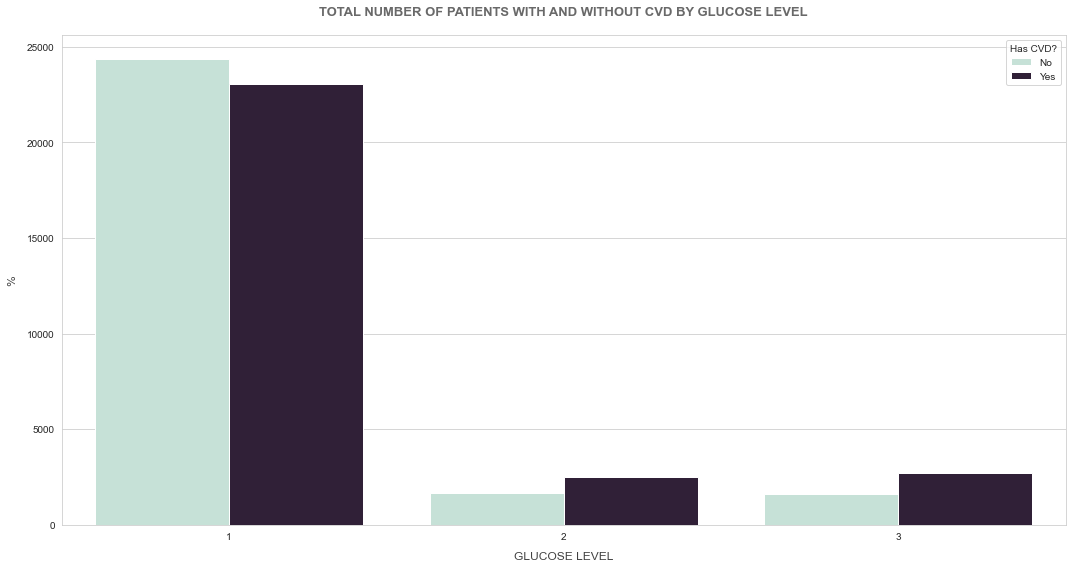

In [53]:
plt.figure(figsize=[15,8])
sns.countplot('gluc', hue = 'cardio', data = df4, palette='ch:start=.5,rot=-.5')
plt.title('TOTAL NUMBER OF PATIENTS WITH AND WITHOUT CVD BY GLUCOSE LEVEL' , 
          pad = 20,
         fontsize = 13, color ='dimgrey', fontweight = 'bold')
plt.xlabel('GLUCOSE LEVEL', color = '#414141', labelpad = 10, fontsize = 12)
plt.ylabel('%', color = '#414141', labelpad = 10, fontsize = 12)
plt.legend(title = 'Has CVD?', labels=['No', 'Yes'])
plt.tight_layout();

### H8: The proportion of patients with CVD is at least 20% higher among those who drink alcohol.
**<font color='red'>FALSE</font>**: actually, the proportion of patients with CVD is slightly higher among those who don't drink alcohol.

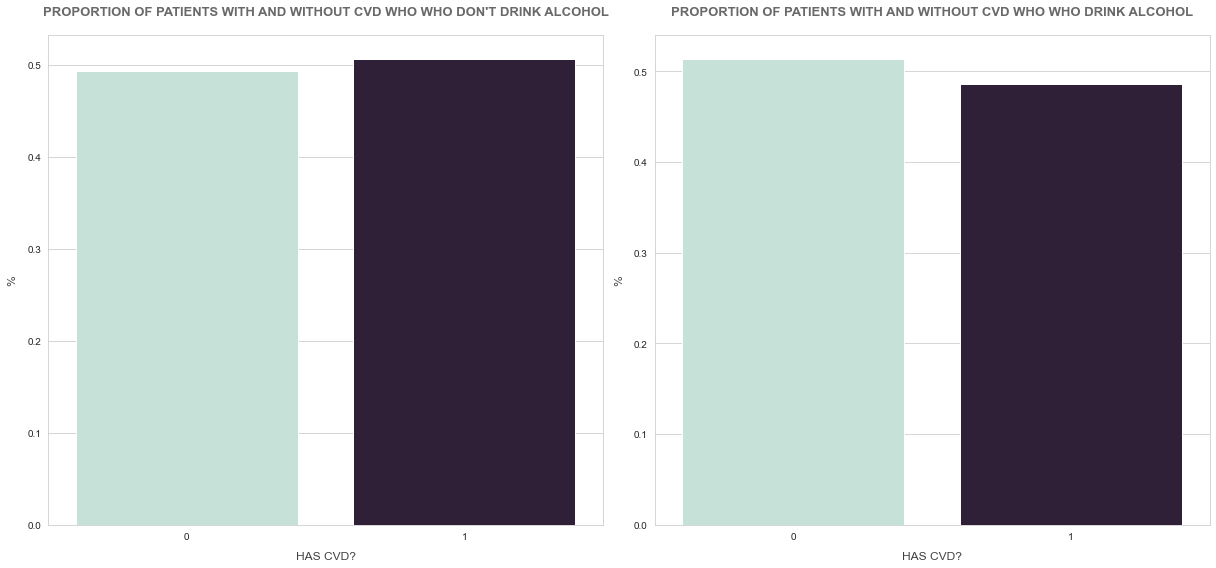

In [56]:
aux1 = df4[df4['alco'] == 0]

plt.figure(figsize=[17,8])

plt.subplot(1,2,1)
sns.barplot(x=aux1.cardio.value_counts(normalize=True).index, y=aux1.cardio.value_counts(normalize=True), palette='ch:start=.5,rot=-.5')
plt.title('PROPORTION OF PATIENTS WITH AND WITHOUT CVD WHO WHO DON\'T DRINK ALCOHOL', 
          pad = 20,
         fontsize = 13, color ='dimgrey', fontweight = 'bold')
plt.xlabel('HAS CVD?', color = '#414141', labelpad = 10, fontsize = 12)
plt.ylabel('%', color = '#414141', labelpad = 10, fontsize = 12)
plt.tight_layout();


aux2 = df4[df4['alco'] == 1]

plt.subplot(1,2,2)
sns.barplot(x=aux2.cardio.value_counts(normalize=True).index, y=aux2.cardio.value_counts(normalize=True), palette='ch:start=.5,rot=-.5')
plt.title('PROPORTION OF PATIENTS WITH AND WITHOUT CVD WHO WHO DRINK ALCOHOL', 
          pad = 20,
         fontsize = 13, color ='dimgrey', fontweight = 'bold')
plt.xlabel('HAS CVD?', color = '#414141', labelpad = 10, fontsize = 12)
plt.ylabel('%', color = '#414141', labelpad = 10, fontsize = 12)
plt.tight_layout();

### H9: Among obese patients who have a high blood pressure, at least 50% have CVD.
**<font color='green'>TRUE</font>**: more than 80% of hypertensive and obese patients have CVD.

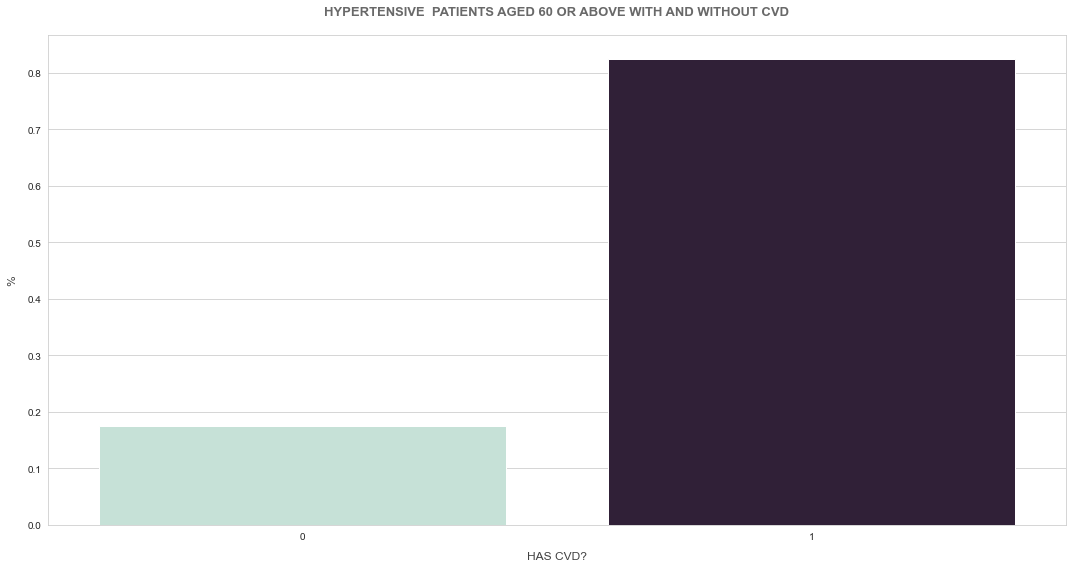

In [58]:
aux1 = df4[(df4['bmi'] >=30) & (df4['blood_pressure'] =='hypertension')]

plt.figure(figsize=[15,8])
sns.barplot(x=aux1.cardio.value_counts(normalize=True).index, y=aux1.cardio.value_counts(normalize=True), palette='ch:start=.5,rot=-.5')
plt.title('HYPERTENSIVE  PATIENTS AGED 60 OR ABOVE WITH AND WITHOUT CVD', 
          pad = 20,
         fontsize = 13, color ='dimgrey', fontweight = 'bold')
plt.xlabel('HAS CVD?', color = '#414141', labelpad = 10, fontsize = 12)
plt.ylabel('%', color = '#414141', labelpad = 10, fontsize = 12)
plt.tight_layout();

### H10: Among patients with CVD, the proportion of those with a cholesterol level above/well above normal is higher in obese patients.
**<font color='green'>TRUE</font>**: the proportion of patients with CVD and a cholesterol above/well above normal is higher among obese.

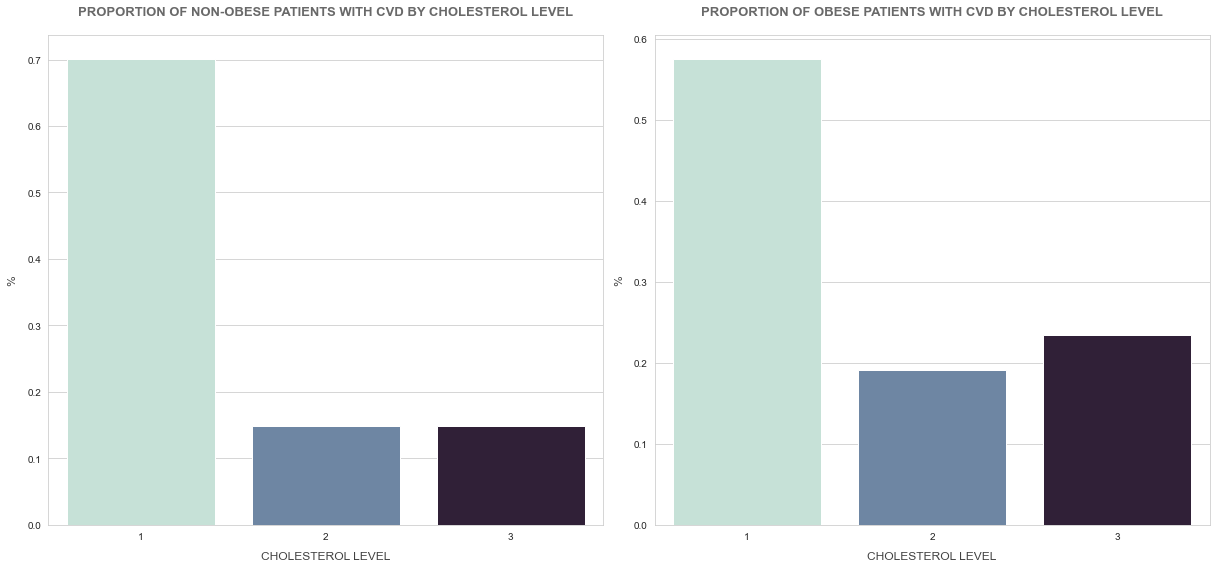

In [63]:
aux1 = df4[(df4['cardio'] == 1) & (df4['bmi'] < 30)]
aux2 = df4[(df4['cardio'] == 1) & (df4['bmi'] >= 30)]
plt.figure(figsize=[17,8])

plt.subplot(1,2,1)
sns.barplot(x=aux1.cholesterol.value_counts(normalize=True).index, y=aux1.cholesterol.value_counts(normalize=True), palette='ch:start=.5,rot=-.5')
plt.title('PROPORTION OF NON-OBESE PATIENTS WITH CVD BY CHOLESTEROL LEVEL', 
          pad = 20,
         fontsize = 13, color ='dimgrey', fontweight = 'bold')
plt.xlabel('CHOLESTEROL LEVEL', color = '#414141', labelpad = 10, fontsize = 12)
plt.ylabel('%', color = '#414141', labelpad = 10, fontsize = 12)
plt.tight_layout();

plt.subplot(1,2,2)
sns.barplot(x=aux2.cholesterol.value_counts(normalize=True).index, y=aux2.cholesterol.value_counts(normalize=True), palette='ch:start=.5,rot=-.5')
plt.title('PROPORTION OF OBESE PATIENTS WITH CVD BY CHOLESTEROL LEVEL', 
          pad = 20,
         fontsize = 13, color ='dimgrey', fontweight = 'bold')
plt.xlabel('CHOLESTEROL LEVEL', color = '#414141', labelpad = 10, fontsize = 12)
plt.ylabel('%', color = '#414141', labelpad = 10, fontsize = 12)
plt.tight_layout();

### 4.2.1.  Hypothesis Validation Summary

| Hypothesis | Validation |
| --- | --- |
| H1 | <font color='green'>True</font> |
| H2 | <font color='red'>False</font> |
| H3 | <font color='red'>False</font> |
| H4 | <font color='grey'>Can't Say</font> |
| H5 | <font color='red'>False</font> |
| H6 | <font color='green'>True</font> |
| H7 | <font color='green'>True</font> |
| H8 |  <font color='red'>False</font> |
| H9 | <font color='green'>True</font> |
| H10 |  <font color='green'>True</font> |

## 4.3. Multivariate Analysis

In [4]:
# encoding varaibles so the function can work
df4['blood_pressure'] = df4['blood_pressure'].apply(lambda x: 0 if x == 'low_pressure'
                                       else 1 if x == 'normal'
                                       else 2 if x == 'elevated'
                                       else 3)
df4['bmi_levels'] = df4['bmi_levels'].apply(lambda x: 0 if x == 'underweight'
                                           else 1 if x == 'normal'
                                           else 2 if x == 'overweight'
                                           else 3 if x == 'obese'
                                           else 4)

In [5]:
num_feat = df4[['age','height','weight','ap_hi','ap_lo','bmi']]

bin_feat = df4[['gluc','smoke','alco','active','cardio']]

cat_feat = df4[['gender','cholesterol','gluc','smoke','alco',
                'blood_pressure','bmi_levels','cardio']]

### 4.3.1. Continuous Features + Target

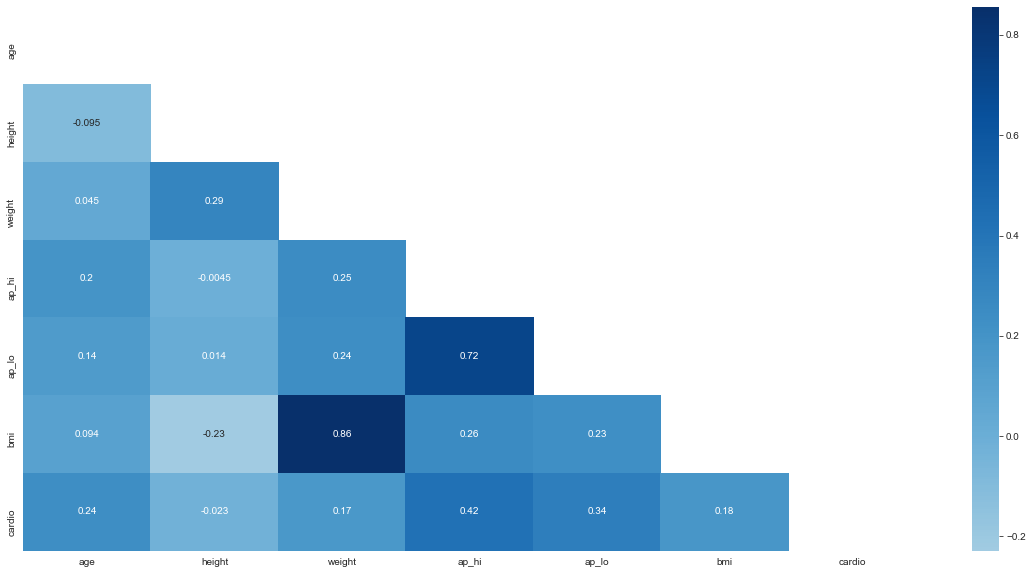

In [8]:
# calculating pearson correlations
df_corr = num_feat.corr(method = 'pearson')

# calculating point-biserial correlations
interest = []
for i, j in enumerate(num_feat.columns):
    result = ss.pointbiserialr(num_feat[f'{j}'], bin_feat['cardio'])[0]
    interest.append(result)
    if i == 5:
        df_corr.loc['cardio'] = interest
        interest.append(1)
df_corr['cardio'] = interest

## plotting
mask = np.zeros_like(df_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.subplots(figsize = (20,10))
sns.heatmap(df_corr,cmap='Blues',mask = mask,annot=True, 
            center = 0,);

**Some Conclusions:**

- Correlation Between features:
    - since `bmi` was derived from `height` and `weight`, we can expect and elevated correlation between them. To avoid colinearity, we'll have to decide which of them to use in the model;
    - `ap_hi` and `ap_lo` are considerably correlated. We could consider using `blood_pressure` in the model instead.
- Correlation Between features and the target:
    - all features have a correlation strong enough to be used in the model, except by the `height` one, which is to close to zero.

### 4.3.2. Categorical Features + Target

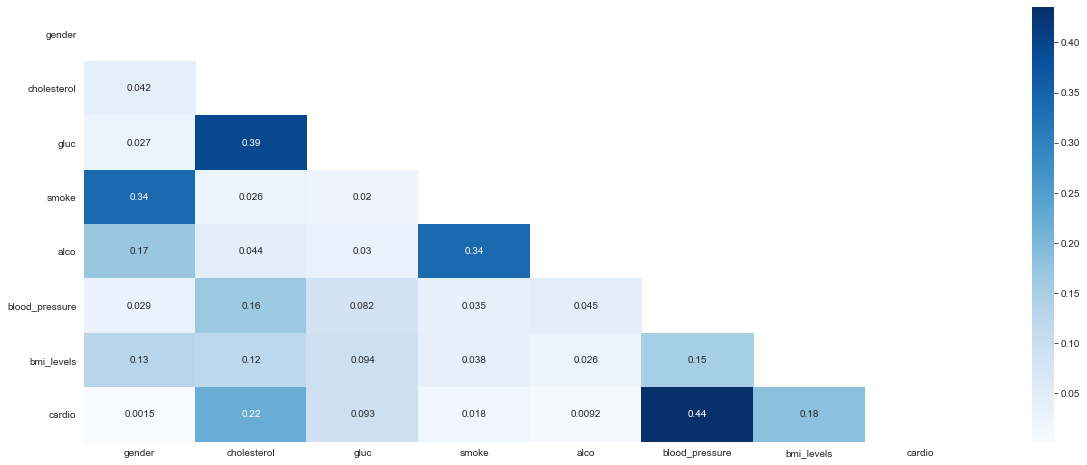

In [7]:
cat_list = cat_feat.columns.tolist()

corr_dict = {}

for i in range(len(cat_list)):
    corr_list = []
    for j in range(len(cat_list)):
        ref = cat_list[i]
        feat = cat_list[j]
        
        # calculating the correlation
        corr = cramer_v(cat_feat[ref], cat_feat[feat])
        
        # appending to the list
        corr_list.append(corr)
    
    corr_dict[ref] = corr_list

cat_corr = pd.DataFrame(corr_dict)
cat_corr = cat_corr.set_index(cat_corr.columns)
mask = np.zeros_like( cat_corr, dtype=np.bool )
mask[np.triu_indices_from( mask )] = True

sns.set_style('whitegrid')
plt.subplots(figsize = (20,8))
sns.heatmap(cat_corr, cmap='Blues', mask = mask, annot=True);

**Some Conclusions:**

- Correlation Between Features:
    - All features have a positive correlation between each other;
    - In general, the correlation between them are week, except by `gluc` with `cholesterol`, `smoke` with `gender` and with `alco`, `blood_pressure` with `bmi_levels` and` cholesterol`, which are moderate or low.
- Correlation Between Features and the Target:
    - the target `cardio` has a moderate correlation with `blood_pressure`;
    - the target `cardio` has a low, but pretty important to model, correlation with `cholesterol` and `bmi_levels`;
    - with respect to the others, the target `cardio` has a extremely low correlation.

# 5.0. STEP 5: DATA PREPARATION

# 6.0. STEP6: FEATURE SELECTION

# 7.0. STEP 7: MACHINE LEARNING MODELS

# 8.0. step 8: HYPERPARAMETER FINE TUNING

# 9.0. STEP 9: CONVERT MODEL PERFORMANCE TO BUSINESS VALUES

# 10.0. STEP 10: DEPLOYING THE MODEL TO PRODUCTION